# 01 - Dataset Overview (Library Borrwings)

This notebook provides a **descriptive overview** of a dataset containing borrowing transactions from the public library in **Tübingen**.
The data records individual borrowing events, including timestamps, loan durations, media-related information, and user category metadata.

## Purpose of this notebook

The goal of this notebook is to:
- introduce the structure and size of the dataset,
- summarize temporal coverage and borrowing volume,
- document the available variables and their completeness,
- provide a neutral, high-level overview of the data.

## Scope and limitations

This notebook is **strictly descriptive**:
- no data cleaning or filtering is performed,
- no assumptions about data quality or causal mechanisms are made,
- no analytical or modeling steps are included.

Data quality checks, consistency validation, and preprocessing decisions are handled in subsequent notebooks.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
from cycler import cycler

plt.rcParams["axes.prop_cycle"] = cycler(color=["#a51e36"])

RAW_DATA_PATH = Path('../dat/raw/borrowings')
PROCESSED_DATA_PATH = Path('../dat/processed')

The data is provided in a separate CSV file for each year.
The entries in the data records vary for each year.

,year,entries
0,2019,393533
1,2020,336369
2,2021,253053
3,2022,306577
4,2023,378329
5,2024,381935
6,2025,357814


Total number of borrowing entries from 2019 to 2025: 2,407,610


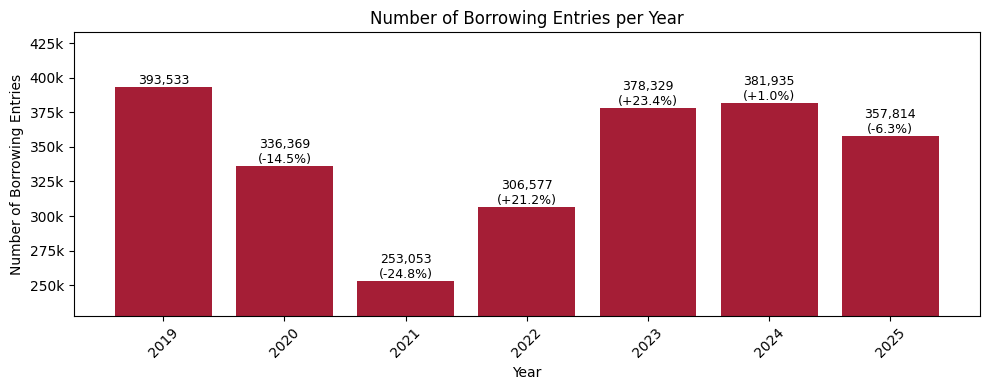

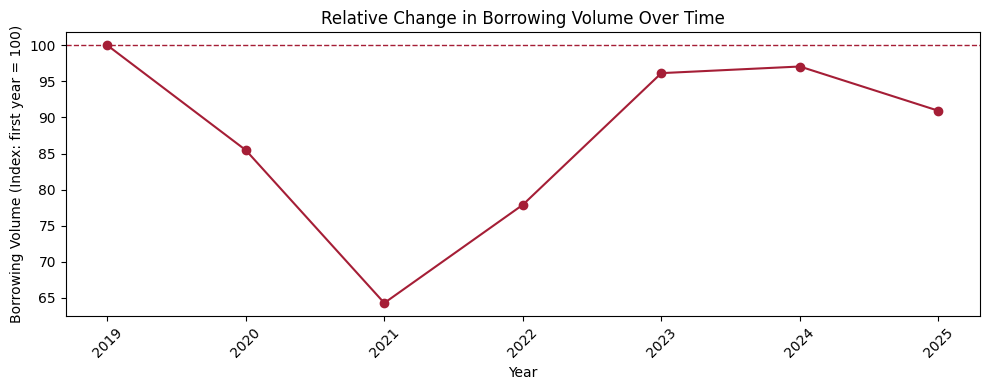

In [9]:
# --- Load yearly files and count entries ---
files = sorted(RAW_DATA_PATH.glob("borrowings_*.csv"))

yearly_counts = {}
years = []

# --- Count entries per year ---
for file in files:
    df = pd.read_csv(file, sep=";", quotechar='"', encoding="utf-8")
    year = file.stem.split("_")[-1]
    yearly_counts[year] = len(df)
    years.append(year)

count_df = (
    pd.DataFrame({"year": list(yearly_counts.keys()), "entries": list(yearly_counts.values())})
    .sort_values(by="year")
    .reset_index(drop=True)
)

display(count_df)

total_entries = count_df["entries"].sum()
print(f"Total number of borrowing entries from {years[0]} to {years[-1]}: {total_entries:,}")

# --- Calculate percentage changes ---
count_df["pct_change"] = count_df["entries"].pct_change() * 100
count_df["index_first_year"] = count_df["entries"] / count_df.loc[0, "entries"] * 100

# --- Plot 1: Bar chart with annotations (absolute + YoY change) ---

def format_thousands(x, pos):
    return f"{int(x/1_000):,}k"

formatter = FuncFormatter(format_thousands)

plt.figure(figsize=(10, 4))
plt.bar(count_df["year"], count_df["entries"])

for _, row in count_df.iterrows():
    label = f"{int(row['entries']):,}"
    if not pd.isna(row["pct_change"]):
        label += f"\n({row['pct_change']:+.1f}%)"
    plt.text(
        row["year"],
        row["entries"],
        label,
        ha="center",
        va="bottom",
        fontsize=9
    )

y_min = count_df["entries"].min() * 0.9
y_max = count_df["entries"].max() * 1.1

plt.xlabel("Year")
plt.ylabel("Number of Borrowing Entries")
plt.title("Number of Borrowing Entries per Year")
plt.xticks(rotation=45)
plt.ylim(y_min, y_max)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

# --- Plot 2: Indexed trend (first year = 100) ---
plt.figure(figsize=(10, 4))
plt.plot(count_df["year"], count_df["index_first_year"], marker="o")
plt.axhline(100, linestyle="--", linewidth=1)

plt.xlabel("Year")
plt.ylabel("Borrowing Volume (Index: first year = 100)")
plt.title("Relative Change in Borrowing Volume Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The borrowing volume shows substantial variation across years, including a pronounced decline followed by a recovery phase. This temporal heterogeneity motivates year-aware analyses in later sections.

In this step, all yearly files are concatenated into a single dataset to enable unified downstream analysis.
No filtering or cleaning is applied at this stage.

In [13]:
# --- Read yearly files and merge into one DataFrame ---
yearly_dfs = []

for csv_path in sorted(files):
    year_df = pd.read_csv(csv_path, sep=";", quotechar='"', encoding="utf-8")
    year_df["source_year"] = csv_path.stem.split("_")[-1]  # keep origin year
    yearly_dfs.append(year_df)

borrowings_df = pd.concat(yearly_dfs, ignore_index=True)
print("Merged shape:", borrowings_df.shape)

# --- Save merged dataset ---
output_path = PROCESSED_DATA_PATH / Path(f"borrowings_{years[0]}_{years[-1]}.csv")
output_path.parent.mkdir(parents=True, exist_ok=True)

borrowings_df.to_csv(
    output_path,
    index=False,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

print(f"Merged data saved to {output_path}")

Merged shape: (2407610, 17)
Merged data saved to ../dat/processed/borrowings_2019_2025.csv


## Column overview

Each row in the dataset represents a single borrowing transaction.

- **issue_id**: Unique identifier of the borrowing transaction *(int)*
- **Ausleihdatum/Uhrzeit**: Date and time when the item was borrowed *(datetime)*
- **Rückgabedatum/Uhrzeit**: Date and time when the item was returned *(datetime)*
- **Leihdauer**: Duration of the loan in days *(int)*
- **Anzahl_Verlängerungen**: Number of times the loan was extended *(int)*
- **Verspätet**: Indicates whether the return was late *(bool)*
- **Tage_zu_spät**: Number of days the return was overdue *(int)*
- **Sammlungszeichen/CCODE**: Internal collection or classification code *(string / category)*
- **Medientyp**: Type of media (e.g. book, DVD) *(string / category)*
- **Barcode**: Unique physical item identifier *(string)*
- **Titel**: Title of the borrowed item *(string)*
- **Autor**: Author of the item *(string)*
- **ISBN**: International Standard Book Number *(string)*
- **Interessenkreis**: Subject or interest category *(string / category)*
- **Benutzerkategorie**: Category of the borrowing user *(string / category)*
- **Benutzer-Systemnummer**: Unique system ID of the user *(string / int)*

In [11]:
# --- Column overview ---
column_overview_df = (
    pd.DataFrame({
        "column": borrowings_df.columns,
        "dtype": [str(borrowings_df[c].dtype) for c in borrowings_df.columns],
        "missing_pct": (borrowings_df.isna().mean() * 100).round(2).values,
        "n_unique": [borrowings_df[c].nunique(dropna=True) for c in borrowings_df.columns],
        "example_value": [
            borrowings_df[c].dropna().iloc[0] if borrowings_df[c].notna().any() else np.nan
            for c in borrowings_df.columns
        ],
    })
    .sort_values("missing_pct", ascending=False)
    .reset_index(drop=True)
)

display(column_overview_df)

,column,dtype,missing_pct,n_unique,example_value
0,Autor,object,39.05,47797,"Bruschke, Gerhard"
1,Interessenkreis,object,37.44,7501,Andere Länder Europa
2,ISBN,object,34.03,125585,9783831904525
3,Sammlungszeichen/CCODE,object,17.39,116,esac
4,Titel,object,17.33,125333,Hamburg - Der besondere Stadtführer
5,Barcode,object,17.33,188646,18143906
6,Medientyp,object,17.33,25,Sachbuch
7,Benutzer-Systemnummer,float64,6.78,21455,26.0
8,Benutzerkategorie,object,6.78,17,MDA
9,Leihdauer,float64,2.03,684,22.0


Although the dataset follows a consistent schema, the completeness of several variables may vary across years.
To provide a first structural indication, the figure below shows how missing rates evolve over the source years.

/tmp/ipykernel_70920/1040185473.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.drop(columns=["source_year"]).isna().mean())


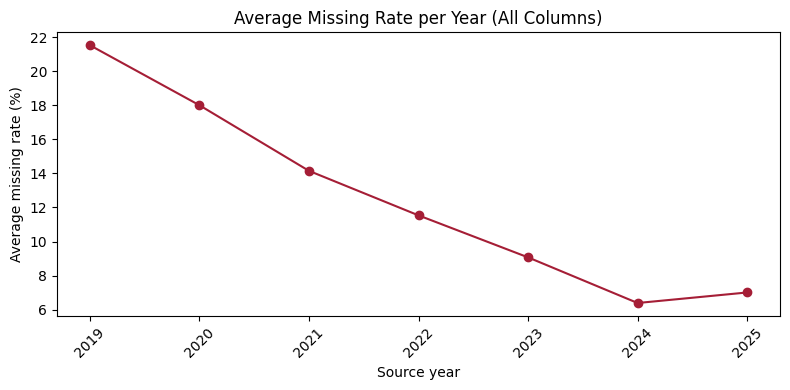

,avg_missing_pct
source_year,
2019,21.53
2020,18.01
2021,14.15
2022,11.54
2023,9.07
2024,6.39
2025,7.01


In [12]:
# --- Missing rate per year (all columns) ---
missing_by_year = (
    borrowings_df
    .groupby("source_year")
    .apply(lambda g: g.drop(columns=["source_year"]).isna().mean())
)

# --- Average missing rate across all columns (per year) ---
avg_missing_by_year = missing_by_year.mean(axis=1) * 100

# plot
plt.figure(figsize=(8, 4))
plt.plot(
    avg_missing_by_year.index,
    avg_missing_by_year.values,
    marker="o"
)

plt.xlabel("Source year")
plt.ylabel("Average missing rate (%)")
plt.title("Average Missing Rate per Year (All Columns)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(
    avg_missing_by_year
    .rename("avg_missing_pct")
    .round(2)
    .to_frame()
)

## Dataset Overview – Key Takeaways

- The merged dataset contains **≈2.4 million borrowing records** spanning **2019–2025**, originally provided as yearly CSV files.
- Borrowing volumes vary notably across years, indicating temporal heterogeneity.
- All files share a consistent schema and were merged into a unified dataset.
- Several descriptive metadata columns show substantial missingness, while core transactional variables are largely complete.
- No cleaning or filtering decisions have been applied at this stage.